In [1]:
from typing import Optional
from typing import Any
from typing import List
from typing import Tuple
from datetime import date
from copy import deepcopy
import os

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
fitness_df: pd.DataFrame = pd.read_feather('data/processed/fitness_df.feather')
fitness_df.set_index('date', inplace=True)
fitness_df.head()

sleep  awake  inbed  bed_time  rise_time  sleep_score  \
date                                                                
2023-01-27  225.0   38.0  263.0  3.383333   7.775000           67   
2023-01-28  397.0   54.0  451.0  2.058333   9.583333           82   
2023-01-29  386.0   34.0  420.0  0.541667   7.541667           83   
2023-01-30  337.0   70.0  407.0  0.191667   6.983333           72   
2023-01-31  631.0  125.0  756.0 -0.258333  12.341667           75   

            calories_today  stress_today  upper_pressure_today  \
date                                                             
2023-01-27         3501.51     71.860465            121.333333   
2023-01-28         3872.51     71.000000            121.333333   
2023-01-29         3810.67     70.000000            121.333333   
2023-01-30         3566.75     64.000000            121.333333   
2023-01-31         3676.57     66.000000            121.333333   

            lower_pressure_today  walk_today  distance_today  \
date                                                           
2023-01-27             78.777778     18547.0       1383590.0   
2023-01-28             78.777778     18519.0       1381320.0   
2023-01-29             78.777778     25897.0       1932110.0   
2023-01-30             78.777778     16226.0       1210620.0   
2023-01-31             78.777778     26014.0       1939840.0   

            n_intermediate_wake_ups  readiness_score  calories_before_sleep  \
date                                                                          
2023-01-27                        1              0.0            3443.431899   
2023-01-28                        1              0.0            3501.510000   
2023-01-29                        0              0.0            3872.510000   
2023-01-30                        2              1.0            3810.670000   
2023-01-31                        6              1.0            3566.750000   

            stress_before_sleep  walk_before_sleep  distance_before_sleep  
date                                                                       
2023-01-27            71.844420       19145.205426           1.428152e+06  
2023-01-28            71.860465       18547.000000           1.383590e+06  
2023-01-29            71.000000       18519.000000           1.381320e+06  
2023-01-30            70.000000       25897.000000           1.932110e+06  
2023-01-31            64.000000       16226.000000           1.210620e+06

In [3]:
def create_df_prophet(fitness_df: pd.DataFrame, 
                      column_name: str, 
                      exogenous: Optional[str]=None) -> pd.DataFrame:
    """ Creates Prophet-compatible dataframe. 
    
    Args:
        fitness_df: The source dataframe to base on.
        column_name: The name of the target column.
        exogenous: The name of the column with exogenous regressor. 
            None means no exogenous regressor.
            
    Returns:
        Prophet-compatible dataframe.
    """
    src_select_list: List[str] = [column_name]
    dst_select_list: List[str] = ['ds', 'y']
    if exogenous is not None:
        src_select_list.append(exogenous)
        dst_select_list.append(exogenous)
    
    prophet_df: pd.DataFrame = fitness_df[src_select_list]
    
    prophet_df['ds'] = prophet_df.index
    prophet_df['y'] = prophet_df[column_name]
    
    prophet_df = prophet_df.reset_index()[dst_select_list]
    today: str = date.today().strftime("%d-%m-%Y")
    prophet_df.to_feather(f"data/processed/prophet_df_{column_name}_{today}.feather")
    
    return prophet_df

In [4]:
def fit_prophet(prophet_df: pd.DataFrame, 
                exogenous: Optional[str]=None) -> Tuple[Prophet, Any]:
    """ Fits Facebook Prophet. 
    
    Args:
        prophet_df: Prophet-compatible dataframe.
        exogenous: The name of columns with exogenous variables. 
            No exogenous regressors when None.
    """
    model: Prophet = Prophet()
    if exogenous is not None:
        model.add_regressor(exogenous)
    model.fit(prophet_df)
    n_periods: int = 30
    future: Any = model.make_future_dataframe(periods=n_periods)
    if exogenous is not None:
        regressor: np.array = np.zeros_like(future['ds'].values, dtype=np.float32)
        seasonality: int = 7
        value_list: List[float] = prophet_df[exogenous].values.tolist()
        
        idx: int
        for idx in range(len(regressor)):
            if idx < len(value_list):
                regressor[idx] = value_list[idx]
            else:
                regressor[idx] = np.mean(value_list[(idx % seasonality):][::seasonality])
        future[exogenous] = regressor
    forecast: Any = model.predict(future)
    return model, forecast

In [5]:
model: Prophet; forecast: Any; ts_figure: Any; ts_components: Any
IMG_ROOT: str = 'export/images/prophet/'
os.makedirs(IMG_ROOT, exist_ok=True)

# Minutes Asleep

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:36 - cmdstanpy - INFO - Chain [1] done processing


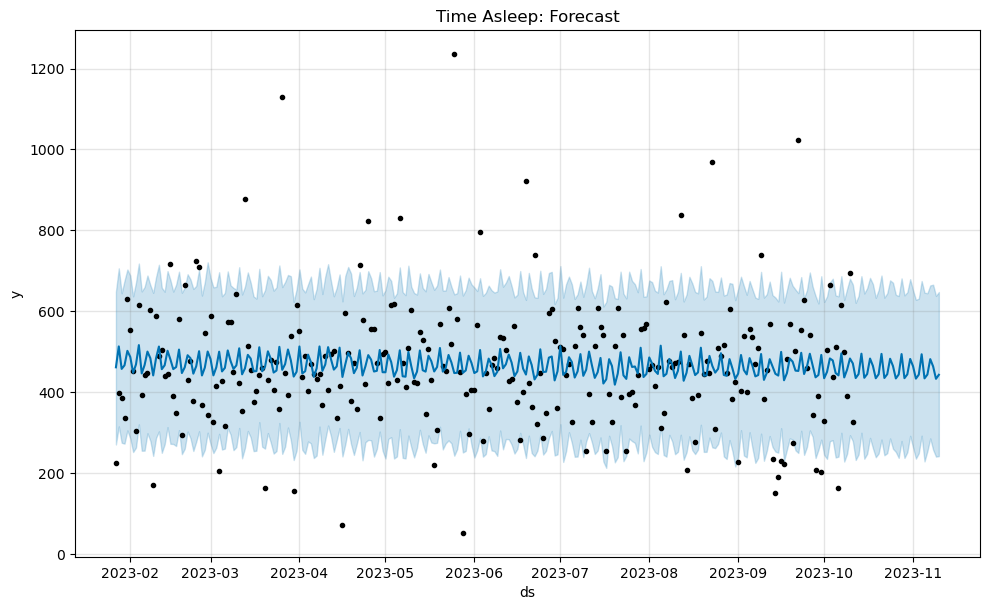

In [6]:
asleep_df: pd.DataFrame = create_df_prophet(fitness_df, 'sleep', 'calories_before_sleep')
model, forecast = fit_prophet(asleep_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Time Asleep: Forecast")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_time_asleep.png'))
plt.show()

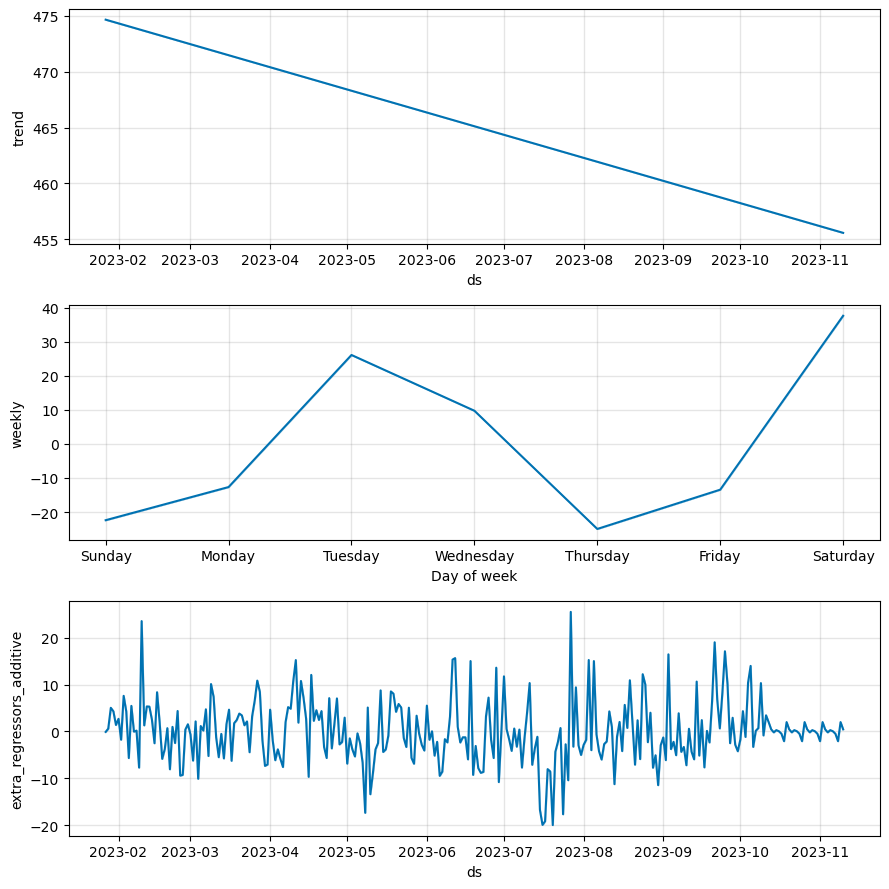

In [7]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_time_asleep.png'))
plt.show()

# Minutes Awake (Instead Sleep)

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:37 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing


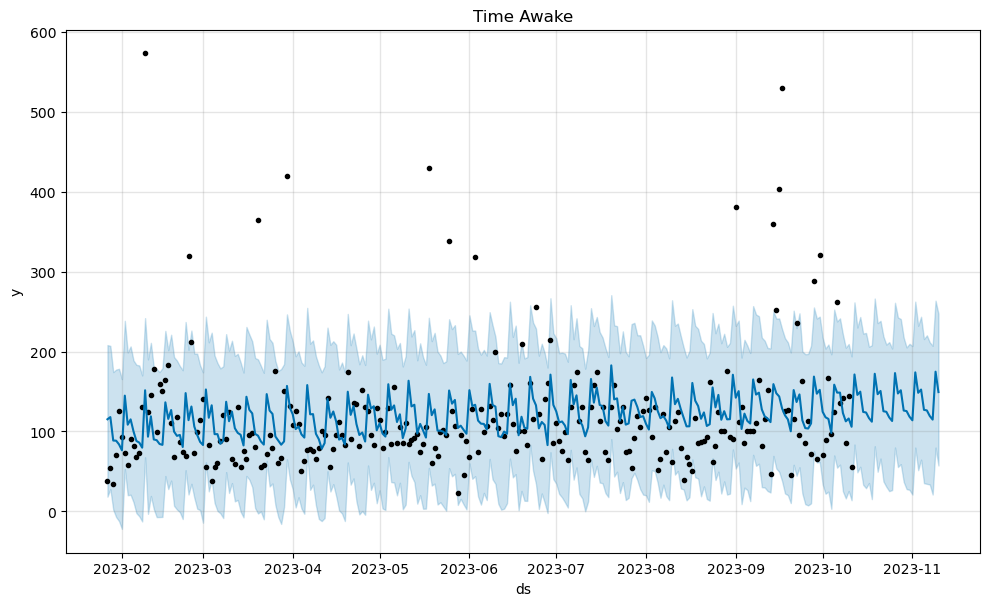

In [8]:
awake_df: pd.DataFrame = create_df_prophet(fitness_df, 'awake', 'calories_before_sleep')
model, forecast = fit_prophet(awake_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Time Awake")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_time_awake.png'))
plt.show()

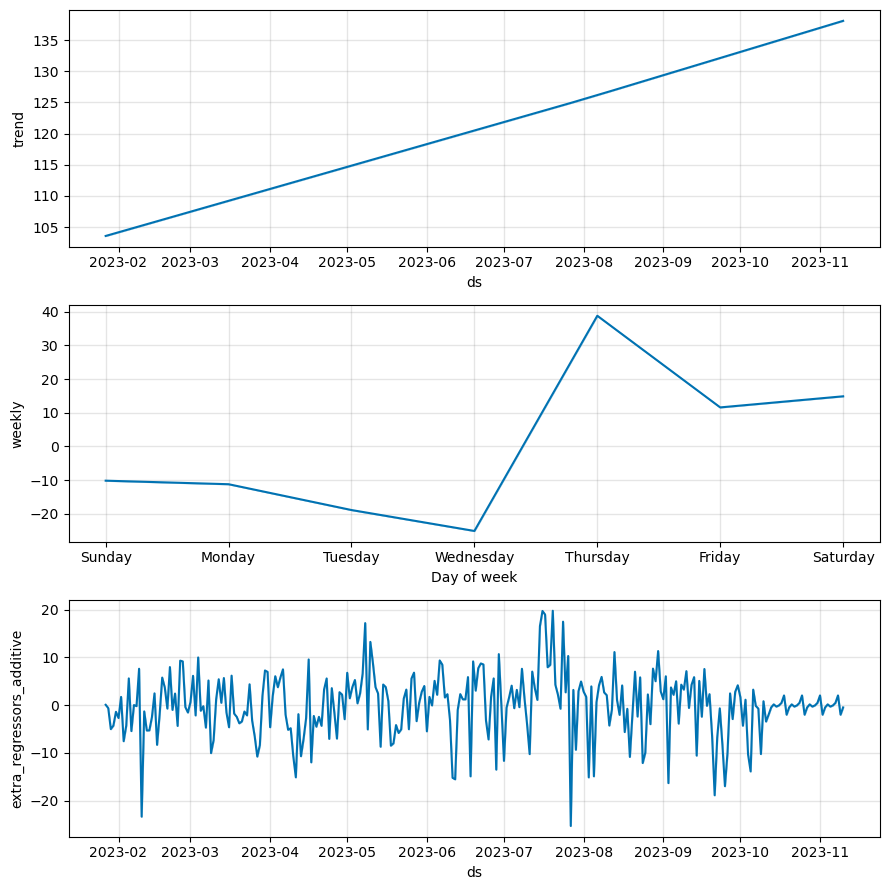

In [9]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_time_awake.png'))
plt.show()

# Minutes Inbed

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:39 - cmdstanpy - INFO - Chain [1] start processing
23:30:39 - cmdstanpy - INFO - Chain [1] done processing


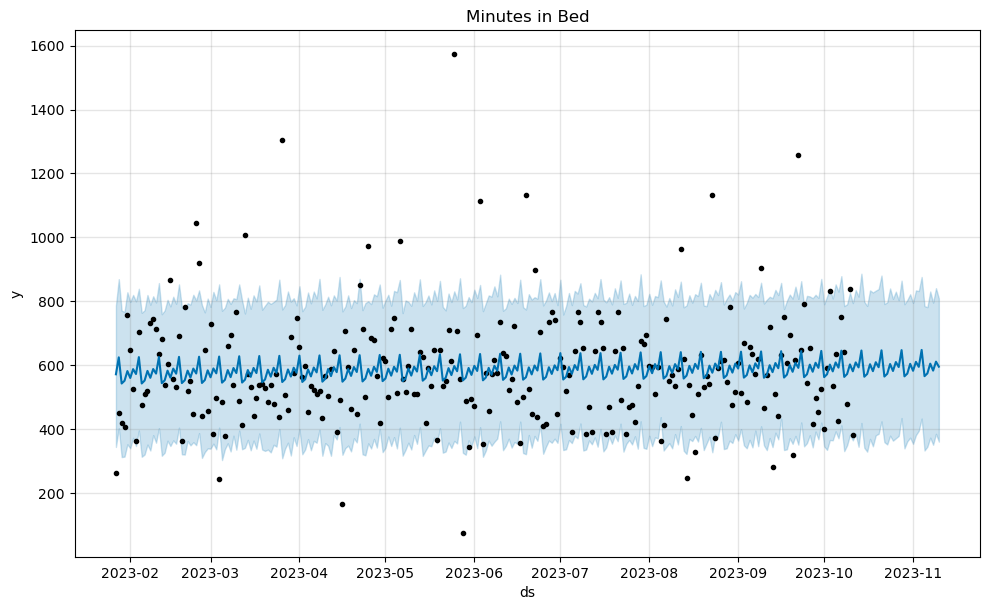

In [10]:
total_df: pd.DataFrame = create_df_prophet(fitness_df, 'inbed', 'calories_before_sleep')
model, forecast = fit_prophet(total_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Minutes in Bed")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_minutes_in_bed.png'))
plt.show()

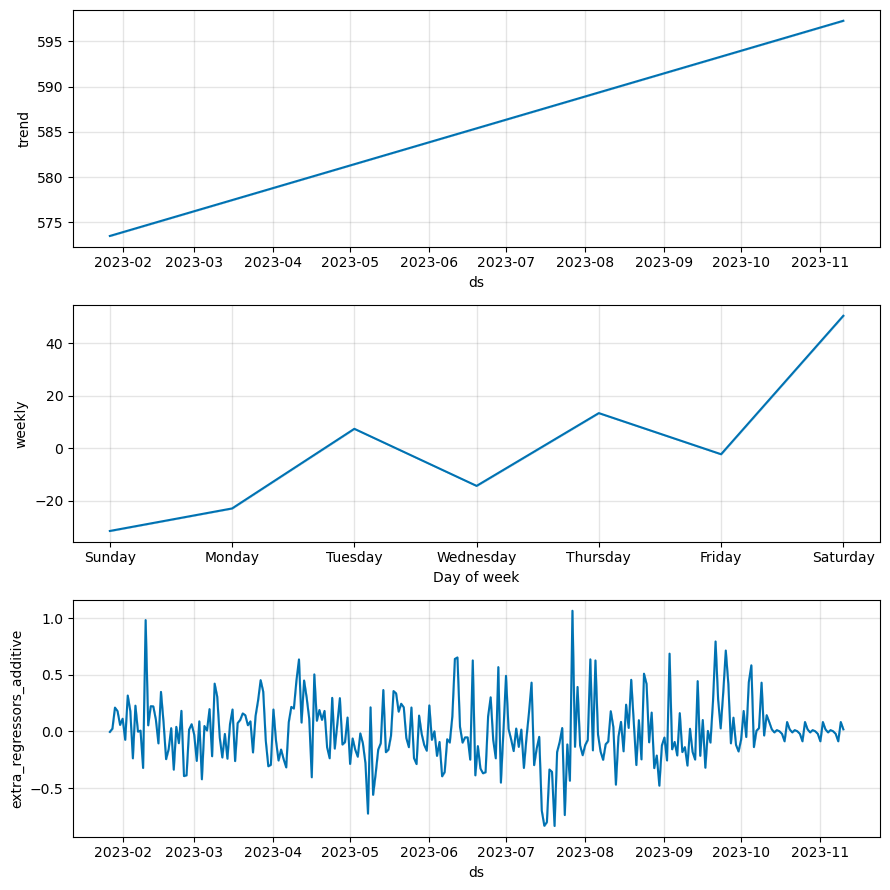

In [11]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_minutes_in_bed.png'))
plt.show()

## Sleep Start

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing


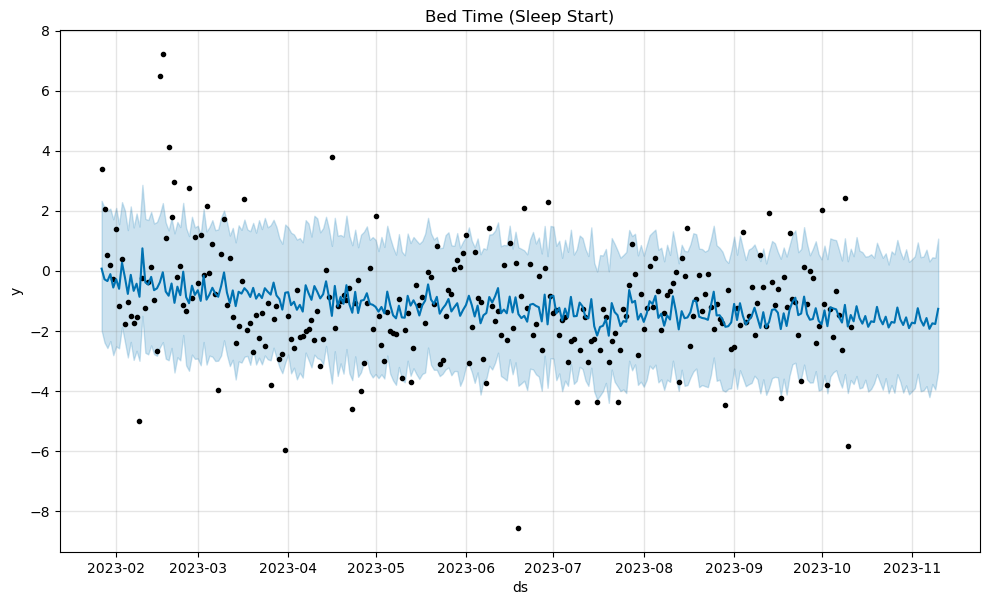

In [12]:
bed_time_df: pd.DataFrame = create_df_prophet(fitness_df, 'bed_time', 'calories_before_sleep')
model, forecast = fit_prophet(bed_time_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Bed Time (Sleep Start)")
plt.savefig(os.path.join(IMG_ROOT, "forecast_bed_time.png"))
plt.show()

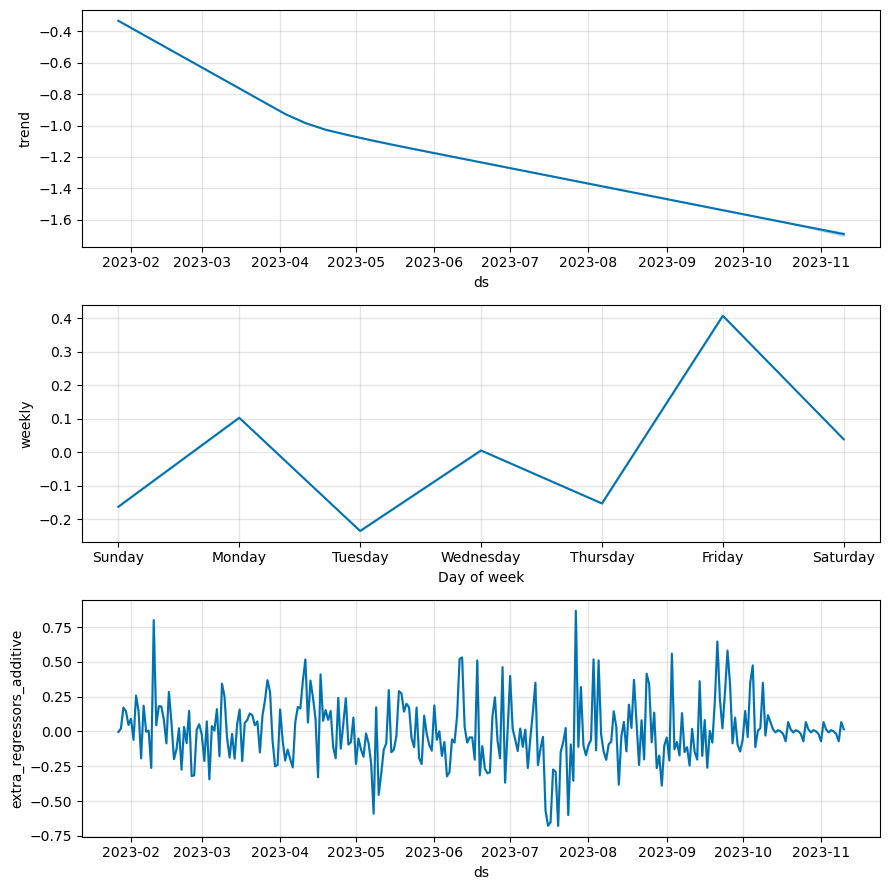

In [13]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, "components_bed_time.png"))
plt.show()

## Rise Time

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:42 - cmdstanpy - INFO - Chain [1] start processing
23:30:42 - cmdstanpy - INFO - Chain [1] done processing


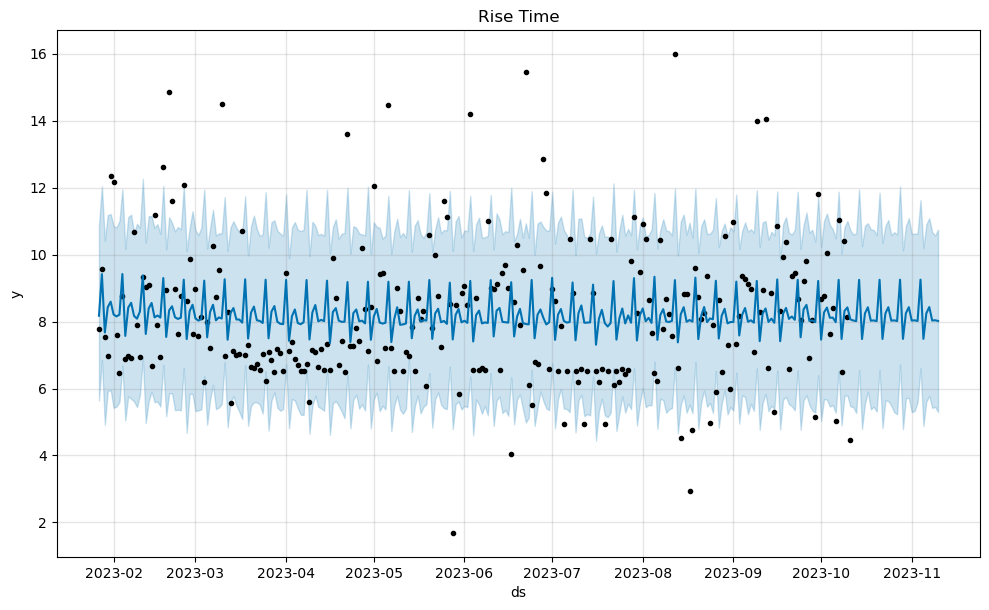

In [14]:
rise_time_df: pd.DataFrame = create_df_prophet(fitness_df, 'rise_time', 'calories_before_sleep')
model, forecast = fit_prophet(rise_time_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Rise Time")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_rise_time.png'))
plt.show()

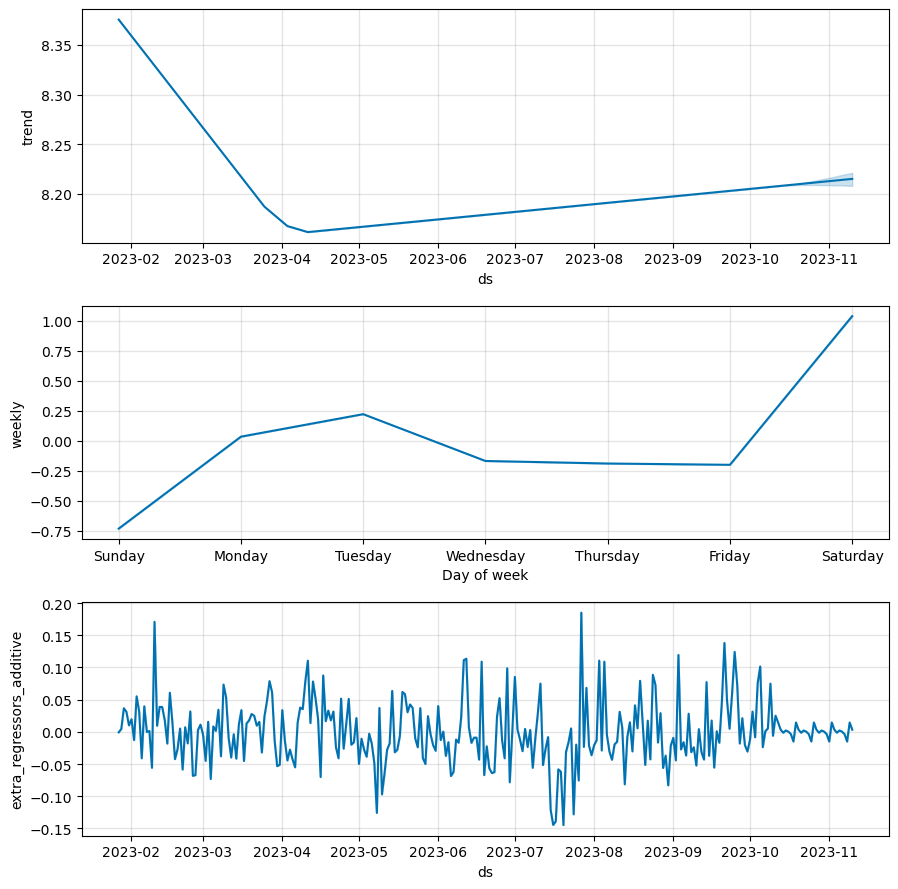

In [15]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_rise_time.png'))
plt.show()

# Sleep Score

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:43 - cmdstanpy - INFO - Chain [1] start processing
23:30:43 - cmdstanpy - INFO - Chain [1] done processing


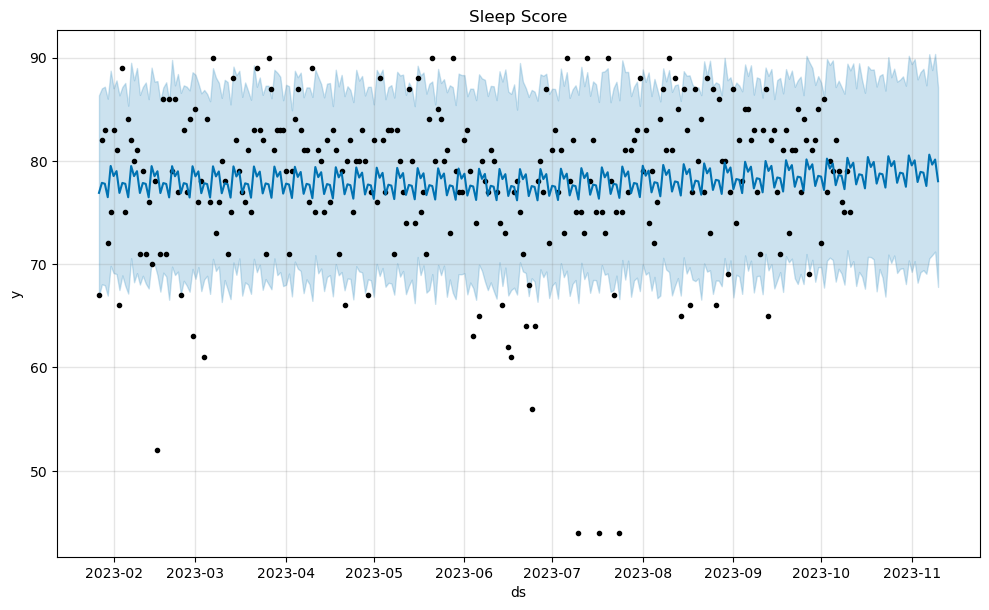

In [16]:
score_df: pd.DataFrame = create_df_prophet(fitness_df, 'sleep_score')
model, forecast = fit_prophet(score_df)
model.plot(forecast)
plt.title("Sleep Score")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_sleep_score.png'))
plt.show()

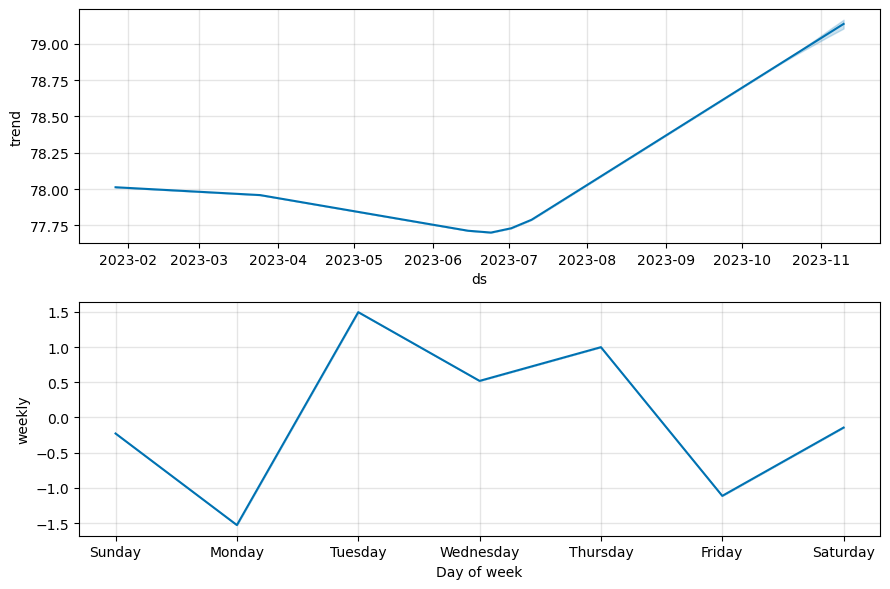

In [17]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_sleep_score.png'))
plt.show()

## Intermediate Wake Ups

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:44 - cmdstanpy - INFO - Chain [1] start processing
23:30:44 - cmdstanpy - INFO - Chain [1] done processing


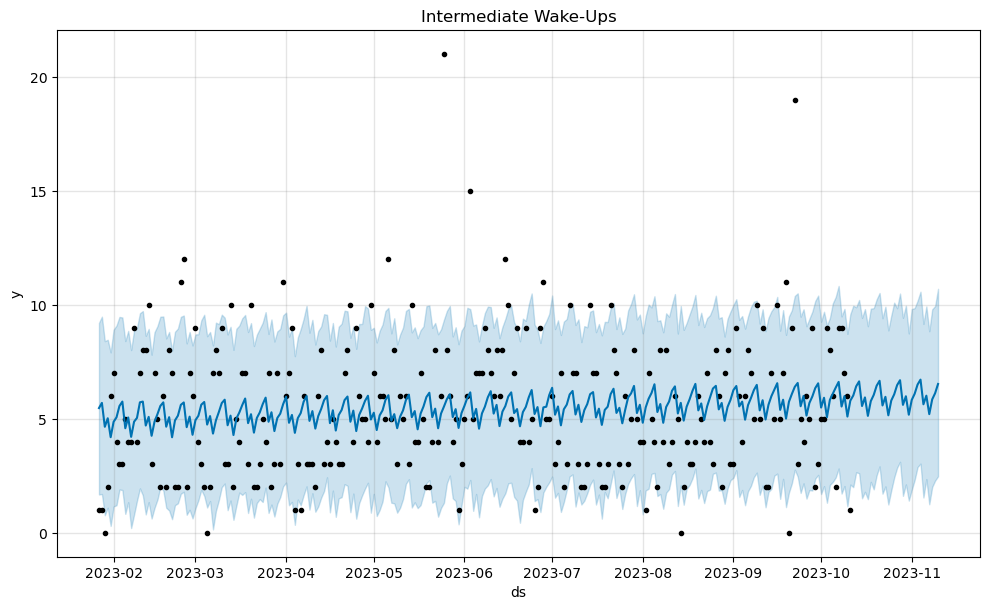

In [18]:
n_wake_df: pd.DataFrame = create_df_prophet(fitness_df, 'n_intermediate_wake_ups', 'calories_before_sleep')
model, forecast = fit_prophet(n_wake_df, 'calories_before_sleep')
model.plot(forecast)
plt.title("Intermediate Wake-Ups")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_n_wake_ups.png'))
plt.show()

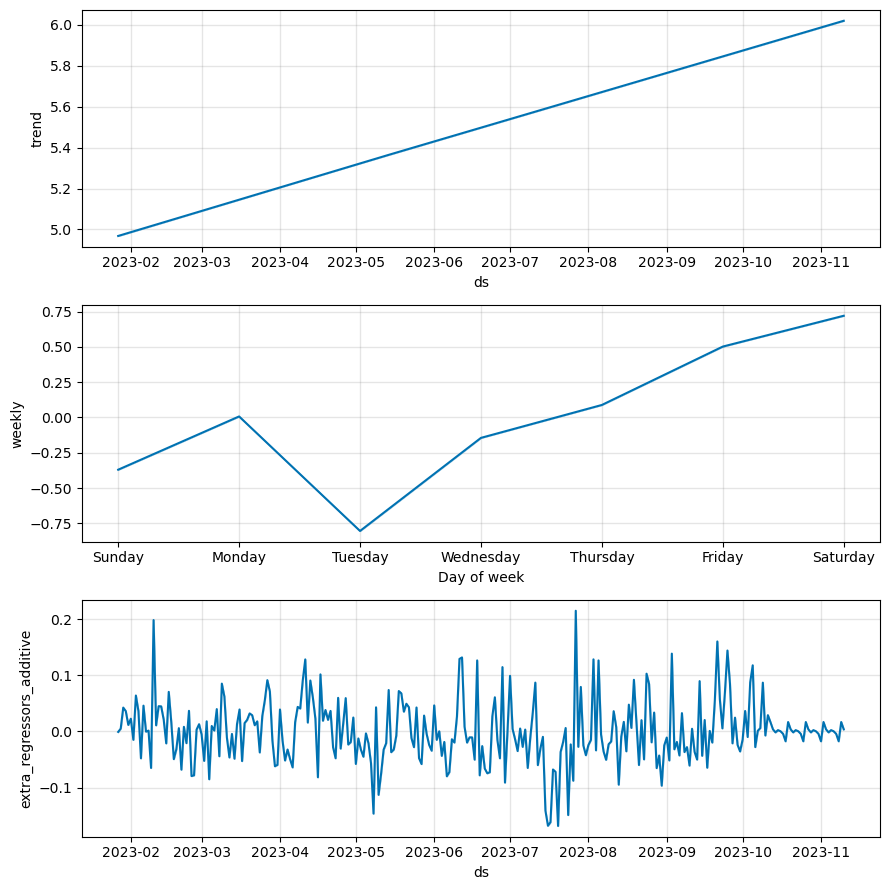

In [19]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_n_wake_ups.png'))
plt.show()

# Stress Score

Higher is Better

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:46 - cmdstanpy - INFO - Chain [1] start processing
23:30:46 - cmdstanpy - INFO - Chain [1] done processing


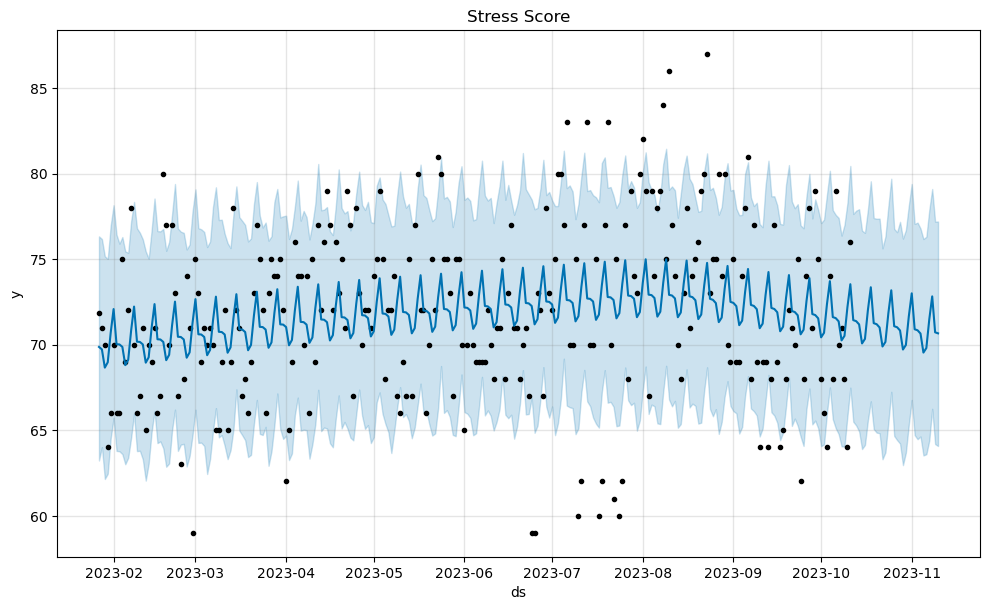

In [20]:
stress_df: pd.DataFrame = create_df_prophet(fitness_df, 'stress_today')
model, forecast = fit_prophet(stress_df)
model.plot(forecast)
plt.title("Stress Score")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_stress_score.png'))
plt.show()

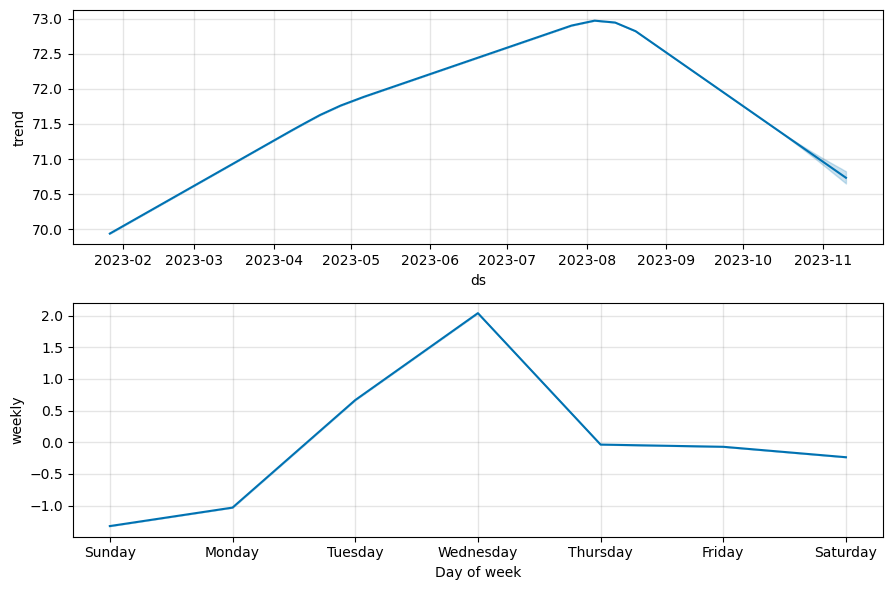

In [21]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_stress_score.png'))
plt.show()

## Daily Walk in Steps 

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:47 - cmdstanpy - INFO - Chain [1] start processing
23:30:47 - cmdstanpy - INFO - Chain [1] done processing


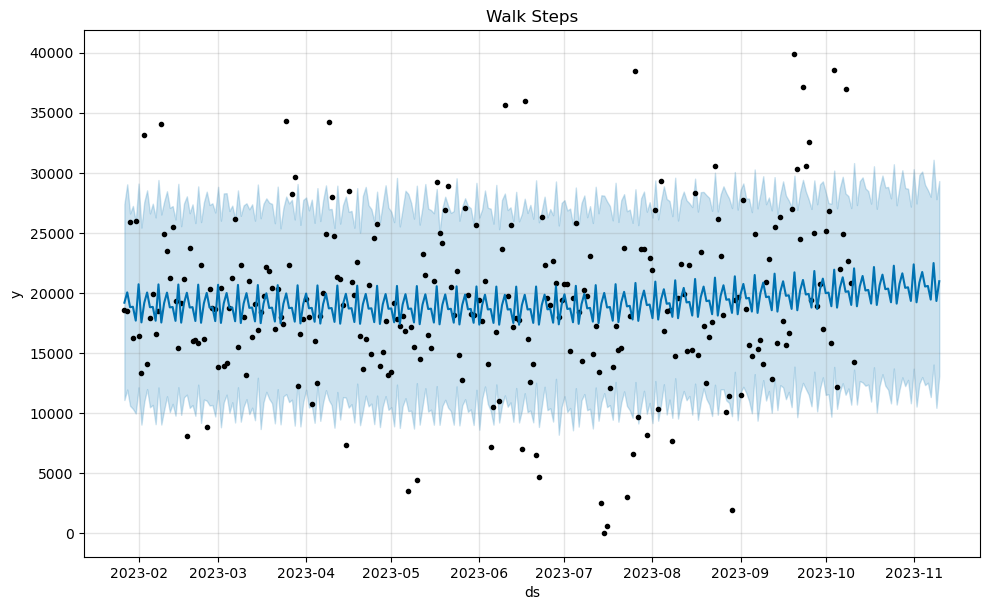

In [22]:
walk_df: pd.DataFrame = create_df_prophet(fitness_df, 'walk_today')
model, forecast = fit_prophet(walk_df)
model.plot(forecast)
plt.title("Walk Steps")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_walk_steps.png'))
plt.show()

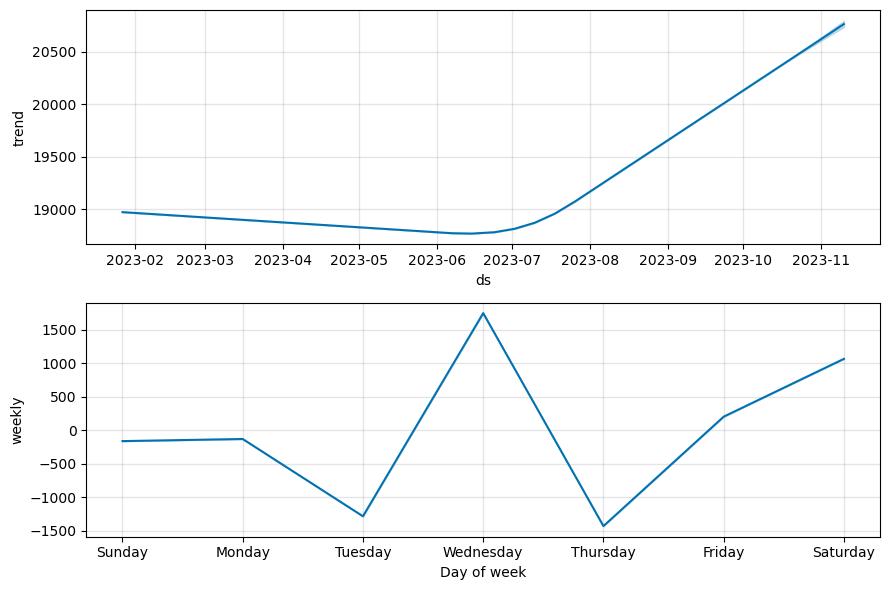

In [23]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_walk_steps.png'))
plt.show()

## Calories Burnt

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing


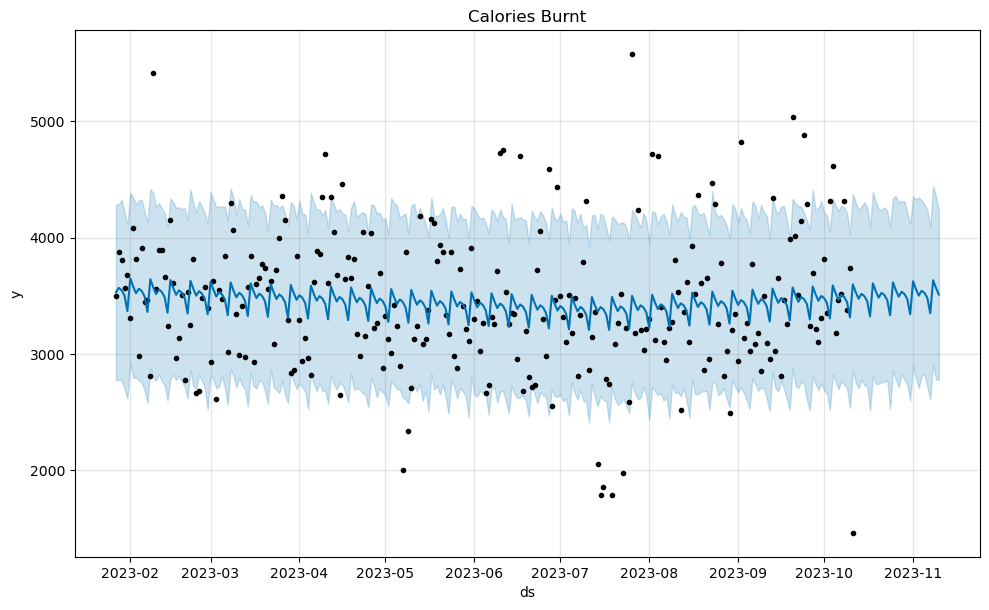

In [24]:
calories_df: pd.DataFrame = create_df_prophet(fitness_df, 'calories_today')
model, forecast = fit_prophet(calories_df)
model.plot(forecast)
plt.title("Calories Burnt")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_calories_burnt.png'))
plt.show()

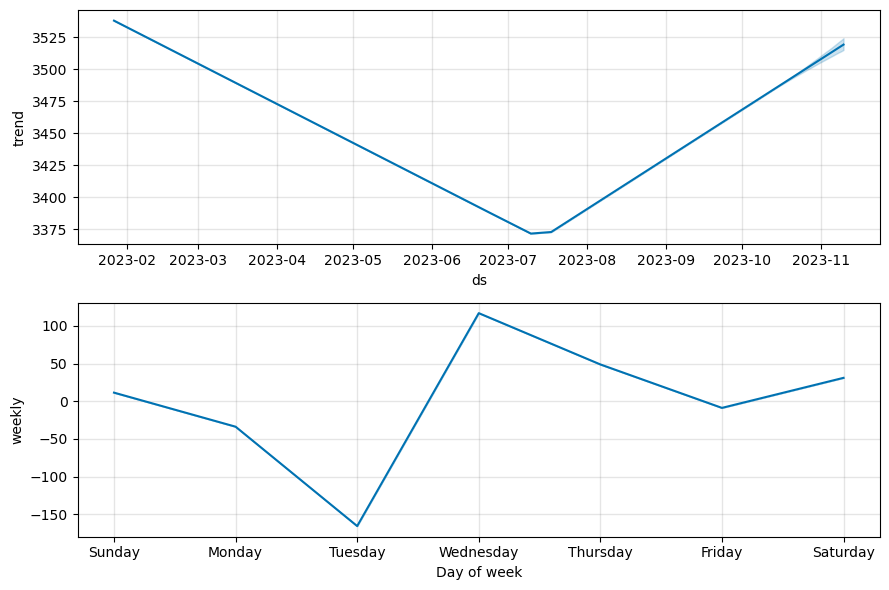

In [25]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_calories_burnt.png'))
plt.show()

## Readiness Score

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:49 - cmdstanpy - INFO - Chain [1] start processing
23:30:49 - cmdstanpy - INFO - Chain [1] done processing


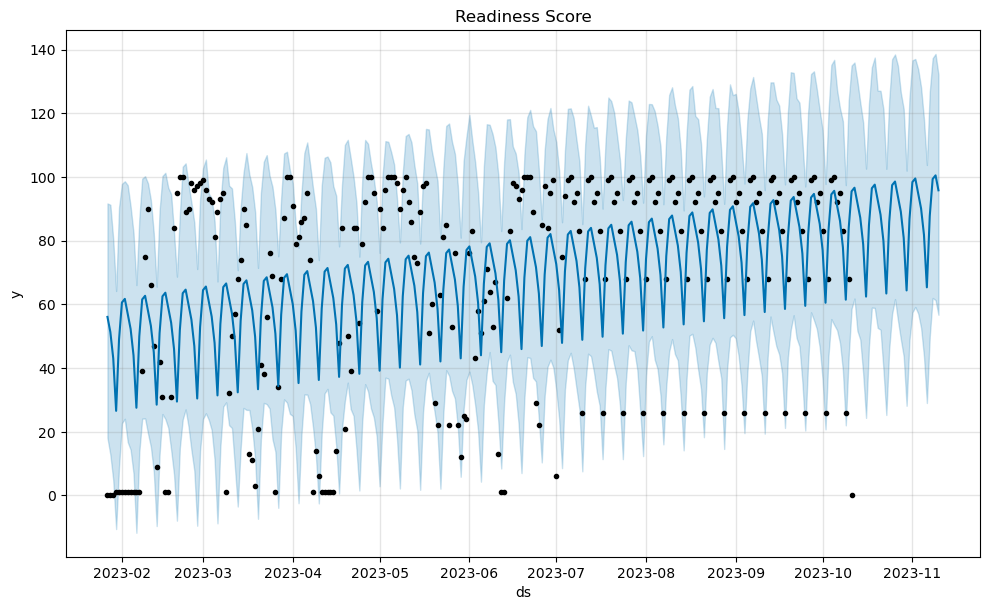

In [26]:
readiness_df: pd.DataFrame = create_df_prophet(fitness_df, 'readiness_score')
model, forecast = fit_prophet(readiness_df)
model.plot(forecast)
plt.title("Readiness Score")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_readiness_score.png'))
plt.show()

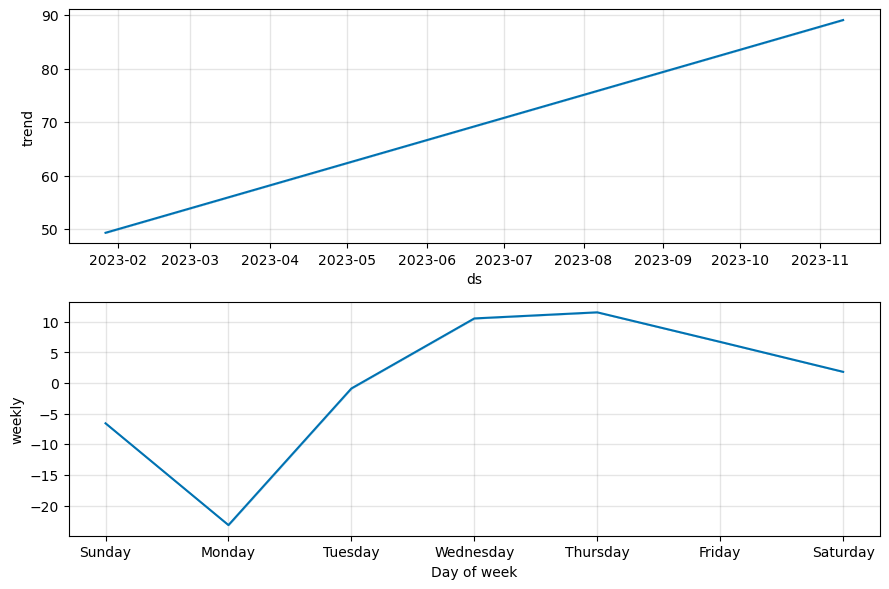

In [27]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_readiness_score.png'))
plt.show()

## Distance 

C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['ds'] = prophet_df.index
C:\Users\nekrald\AppData\Local\Temp\ipykernel_24196\1059981872.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df['y'] = prophet_df[column_name]
23:30:50 - cmdstanpy - INFO - Chain [1] start processing
23:30:50 - cmdstanpy - INFO - Chain [1] done processing


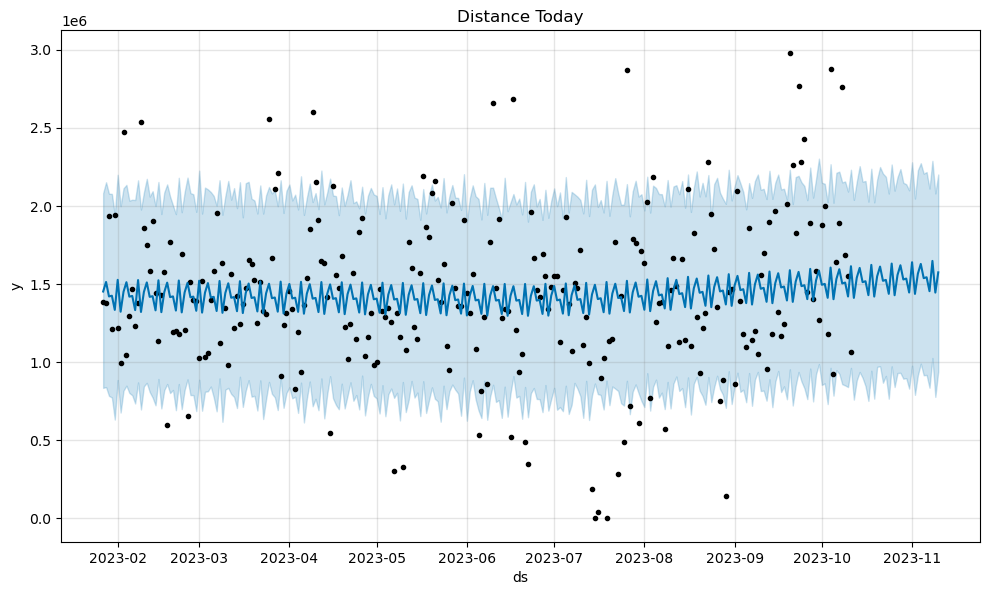

In [28]:
distance_df: pd.DataFrame = create_df_prophet(fitness_df, 'distance_today')
model, forecast = fit_prophet(distance_df)
model.plot(forecast)
plt.title("Distance Today")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_distance.png'))
plt.show()

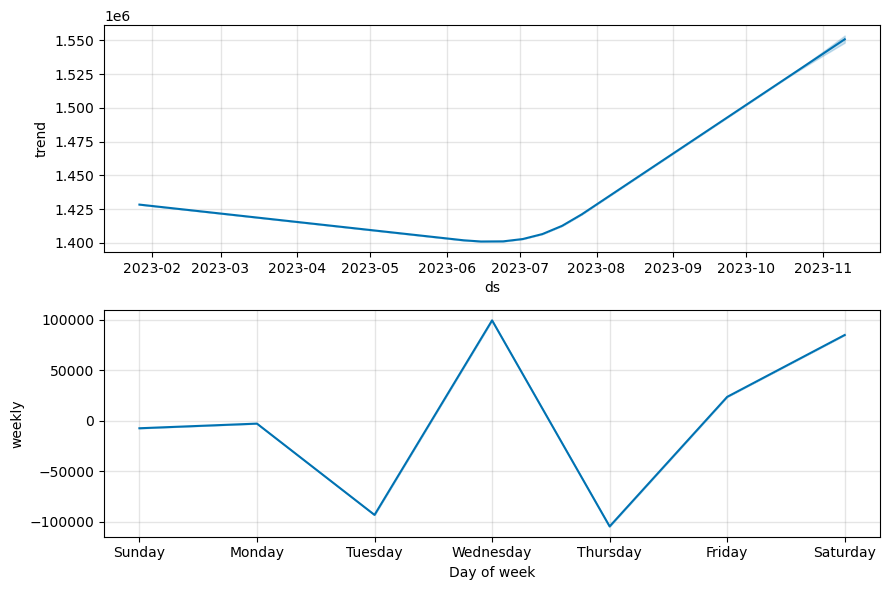

In [29]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_distance.png'))
plt.show()

## Blood Pressure - Higher Value

In [30]:
pressure_df: pd.DataFrame = pd.read_feather("data/processed/raw_pressure.feather")
pressure_df: pd.DataFrame = pressure_df.set_index('date')

23:30:51 - cmdstanpy - INFO - Chain [1] start processing
23:31:00 - cmdstanpy - INFO - Chain [1] done processing


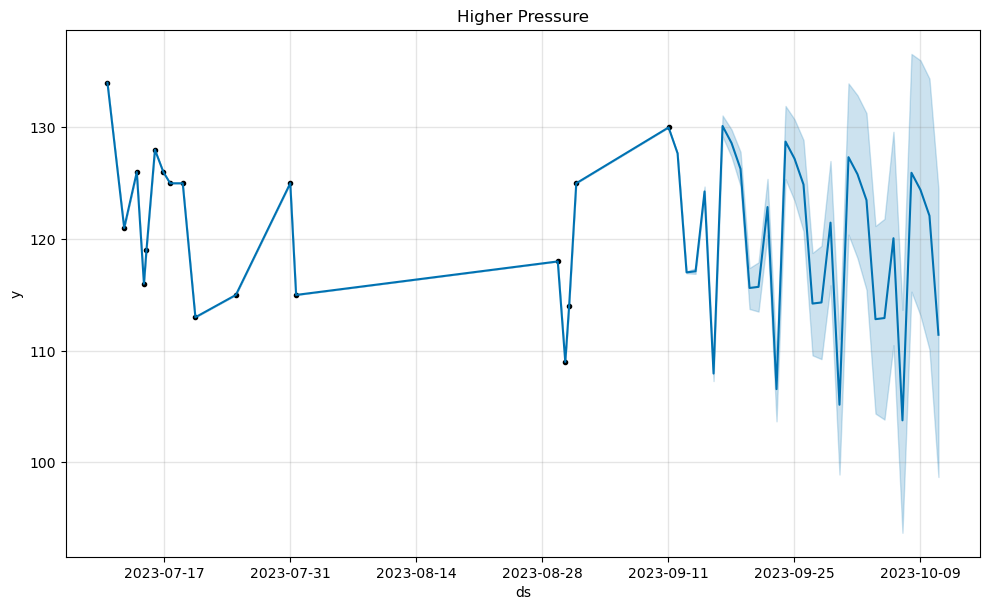

In [31]:
higher_pressure_df: pd.DataFrame = create_df_prophet(pressure_df, 'higher')
model, forecast = fit_prophet(higher_pressure_df)
model.plot(forecast)
plt.title("Higher Pressure")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_higher_pressure.png'))
plt.show()

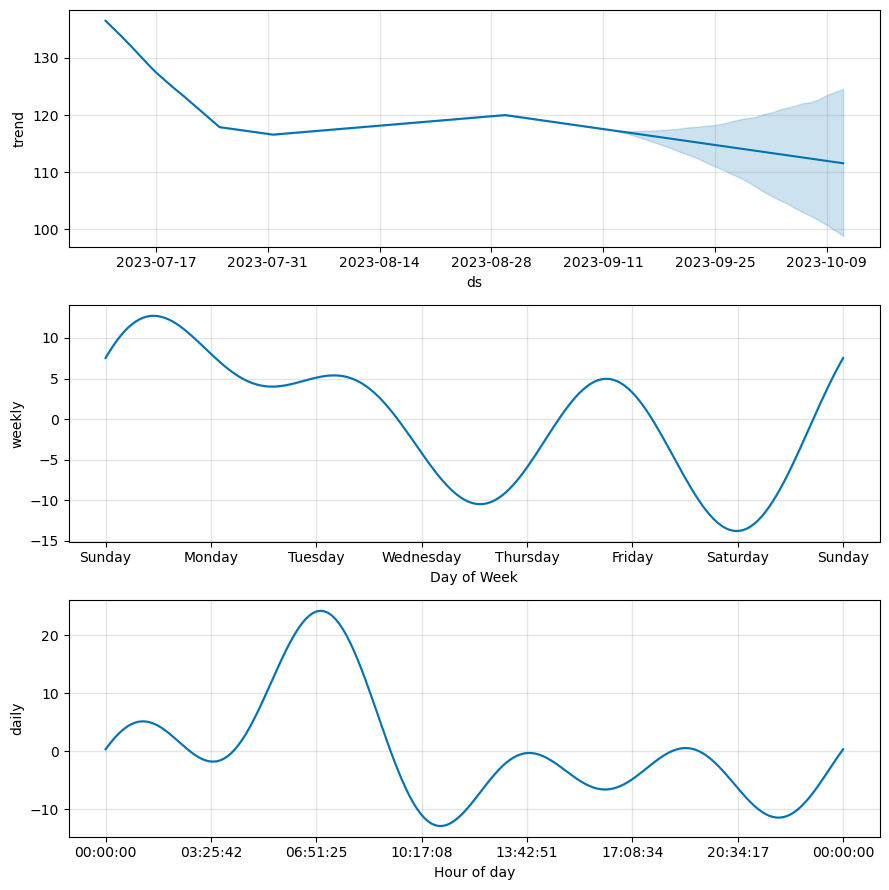

In [32]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_higher_pressure.png'))
plt.show()

## Blood Pressure - Lower Value

23:31:01 - cmdstanpy - INFO - Chain [1] start processing
23:31:10 - cmdstanpy - INFO - Chain [1] done processing


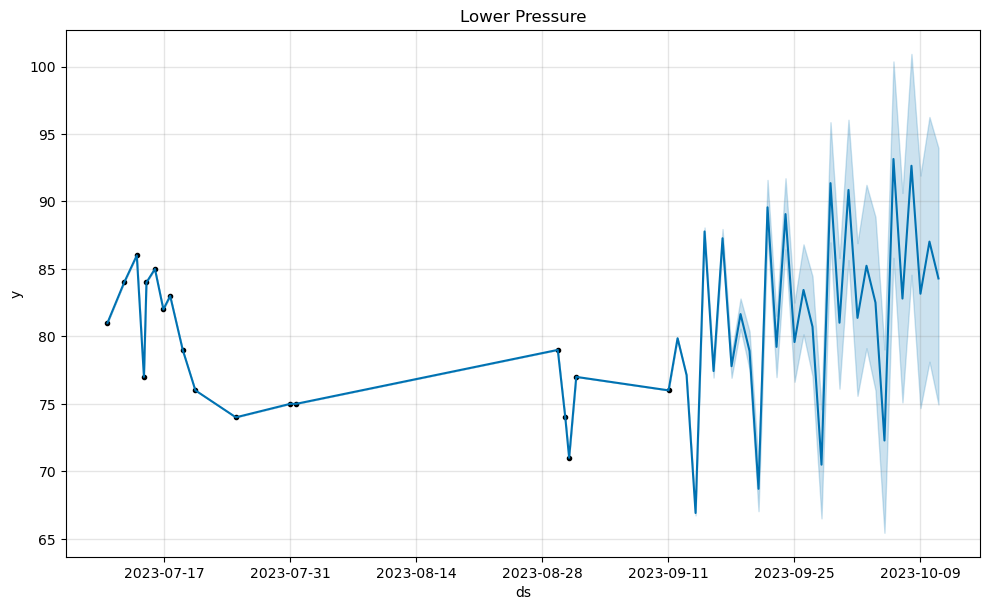

In [33]:
lower_pressure_df: pd.DataFrame = create_df_prophet(pressure_df, 'lower')
model, forecast = fit_prophet(lower_pressure_df)
model.plot(forecast)
plt.title("Lower Pressure")
plt.savefig(os.path.join(IMG_ROOT, 'forecast_lower_pressure.png'))
plt.show()

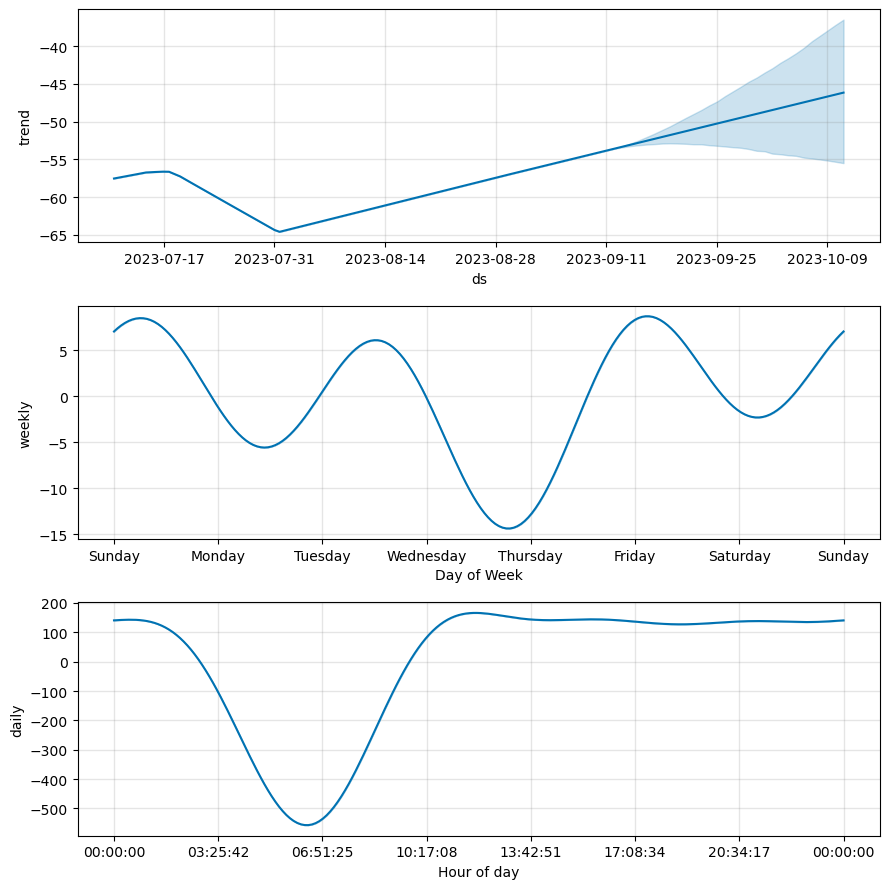

In [34]:
model.plot_components(forecast)
plt.savefig(os.path.join(IMG_ROOT, 'components_lower_pressure.png'))
plt.show()